# Chapter 10: Visual SLAM의 완성 - 카메라로 세상을 3D로 재구성하기 🎥

## ⚠️ 시작하기 전에 반드시 읽으세요!

**ZeroDivisionError나 AlreadyUsedEpsilon 오류가 발생했다면:**
1. **Kernel → Restart Kernel** 메뉴로 커널을 재시작하세요
2. 재시작 후 아래의 epsilon 설정 셀을 첫 번째로 실행하세요
3. 그 다음 순서대로 셀들을 실행하세요

**이 노트북은 SymForce의 epsilon을 설정해야 합니다. 다른 노트북에서 epsilon을 0으로 사용했다면 반드시 커널을 재시작하세요.**

---

**이전 강의 복습:** 이론 강의에서 카메라 모델의 수학적 기초, Bundle Adjustment의 원리, 그리고 수치적 안정성을 보장하는 방법을 배웠습니다.

**이번 실습의 목표:** 
1. 실제 Visual SLAM 시스템의 핵심인 카메라 모델을 직접 구현
2. Bundle Adjustment로 카메라 포즈와 3D 점을 동시에 최적화
3. 수치적 안정성을 보장하는 epsilon 처리 기법 마스터
4. Visual SLAM과 Pose-only SLAM의 차이를 코드로 체험

## 🎯 실습을 통해 얻을 실무 스킬
- **드론/로봇 비전**: 실제 로봇에서 카메라 데이터를 처리하는 방법
- **AR/VR 애플리케이션**: 카메라 추적과 3D 재구성 기술
- **자율주행**: 차량 주변 환경을 3D로 인식하는 기술
- **디버깅 노하우**: 재투영 오차가 수렴하지 않을 때 대처법

## 🌟 이 장이 중요한 이유

Visual SLAM은 현대 기술의 핵심입니다:
- 📱 **스마트폰**: AR 앱이 Visual SLAM으로 가상 객체를 현실에 배치
- 🚗 **자율주행차**: 카메라로 주변 환경을 실시간 3D 지도로 구축
- 🤖 **로봇**: 진공청소기부터 화성 탐사선까지, 시각 정보로 내비게이션
- 🏗️ **건설**: 건물의 정밀한 3D 스캐닝과 진행상황 모니터링
- 🎮 **게임**: VR 헤드셋이 여러분의 머리 움직임을 정확히 추적

## 📚 Visual SLAM의 핵심 개념

### 카메라가 세계를 보는 방법 📷

카메라는 본질적으로 3D 세계를 2D 이미지로 변환하는 수학적 장치입니다:

```
3D 세계 좌표  →  [카메라 변환]  →  2D 이미지 픽셀
   (X,Y,Z)                            (u,v)
```

이 과정에서 **깊이 정보가 손실**되며, 이것이 Visual SLAM의 핵심 도전과제입니다!

### Bundle Adjustment: Visual SLAM의 심장 💪

Bundle Adjustment는 동시에 최적화합니다:
1. **카메라 포즈**: 각 사진을 찍었을 때 카메라의 위치와 방향
2. **3D 랜드마크**: 특징점들의 실제 3D 공간 좌표

"Bundle"이라는 이름은 3D 점에서 카메라로 향하는 빛의 광선들이 번들을 형성하기 때문입니다.

### 🔧 실전 통찰:
- **캘리브레이션이 모든 것의 시작**: 잘못된 내부 파라미터 = 실패한 SLAM
- **특징점 품질이 핵심**: 나쁜 매칭 = 왜곡된 3D 재구성
- **수치적 안정성이 필수**: 작은 오류가 전체 시스템을 망칠 수 있음
- **항상 시각화하라**: 문제를 조기에 발견하는 가장 좋은 방법

> 💡 **실무 팁**: Visual SLAM 프로젝트를 시작할 때 가장 먼저 할 일은 카메라 캘리브레이션입니다. 
> OpenCV의 calibrateCamera나 MATLAB의 Camera Calibrator를 사용하세요!

In [70]:
# IMPORTANT: Run this cell FIRST before anything else!
# This sets up epsilon to avoid division by zero errors

import symforce

try:
    symforce.set_epsilon_to_number(1e-8)
    print("✅ Epsilon이 설정되었습니다. 이제 다음 셀들을 실행할 수 있습니다.")
except symforce.AlreadyUsedEpsilon as e:
    print("⚠️ Epsilon이 이미 사용되었습니다.")
    print(f"   오류: {e}")
    print("\n🔧 해결 방법:")
    print("   1. Kernel → Restart Kernel 메뉴를 클릭하여 커널을 재시작하세요")
    print("   2. 커널이 재시작되면 이 셀부터 다시 실행하세요")
    print("\n💡 팁: 이 오류는 epsilon이 0으로 설정되어 있을 때 발생합니다.")
    print("   커널을 재시작하면 깨끗한 상태에서 다시 시작할 수 있습니다.")

⚠️ Epsilon이 이미 사용되었습니다.
   오류: Cannot set return value of epsilon to 1e-08 after it has already been accessed with value 0.0.

🔧 해결 방법:
   1. Kernel → Restart Kernel 메뉴를 클릭하여 커널을 재시작하세요
   2. 커널이 재시작되면 이 셀부터 다시 실행하세요

💡 팁: 이 오류는 epsilon이 0으로 설정되어 있을 때 발생합니다.
   커널을 재시작하면 깨끗한 상태에서 다시 시작할 수 있습니다.


## 🔧 필요한 라이브러리 임포트

이론 시간에 배운 개념들을 실제 코드로 구현하기 위한 도구들을 준비합니다.

### 라이브러리 역할:
- **SymForce**: 심볼릭 계산과 자동 미분으로 복잡한 야코비안을 자동 계산
- **NumPy**: 효율적인 수치 계산
- **Matplotlib**: 3D 시각화로 결과 확인
- **Codegen**: 최적화를 위한 효율적인 코드 생성

### 💡 실무에서의 epsilon 설정:
- **너무 작으면** (< 1e-15): 부동소수점 정밀도 한계로 오류 발생
- **너무 크면** (> 1e-6): 계산 정확도가 떨어짐
- **권장값**: 1e-8 ~ 1e-10 (대부분의 Visual SLAM에 적합)

### ⚠️ AlreadyUsedEpsilon 오류가 발생하면:
이 오류는 epsilon이 이미 다른 값으로 사용된 후 변경하려고 할 때 발생합니다.
해결 방법:
1. **Kernel → Restart Kernel** 메뉴로 커널을 재시작
2. 이 노트북을 처음부터 다시 실행
3. 또는 이미 설정된 epsilon 값을 그대로 사용

> 🔧 **디버깅 팁**: epsilon 관련 오류가 발생하면 현재 값을 확인하고, 
> 필요시 커널을 재시작하여 깨끗한 상태에서 시작하세요.

In [71]:
import numpy as np
import symforce

# Check current epsilon and only set if needed
try:
    import symforce.symbolic as sf
    current_epsilon = sf.numeric_epsilon
    print(f"현재 epsilon: {current_epsilon}")
    
    # If epsilon is 0 or too small, we need to restart the kernel
    if current_epsilon == 0 or current_epsilon < 1e-15:
        print("⚠️ Epsilon이 너무 작습니다. 커널을 재시작하고 다시 실행하세요.")
        print("   Kernel → Restart Kernel 메뉴를 사용하세요.")
        # Try to set it anyway in case it hasn't been used yet
        try:
            symforce.set_epsilon_to_number(1e-8)
            print("✅ Epsilon을 1e-8로 설정했습니다.")
        except:
            print("❌ Epsilon 설정 실패. 커널 재시작이 필요합니다.")
    else:
        print(f"✅ Epsilon이 이미 적절한 값으로 설정되어 있습니다: {current_epsilon}")
except:
    # If we can't import sf yet, set epsilon first
    symforce.set_epsilon_to_number(1e-8)
    import symforce.symbolic as sf
    print(f"✅ Epsilon을 1e-8로 설정했습니다.")

from symforce import codegen
from symforce.opt.optimizer import Optimizer
from symforce.opt.factor import Factor
from symforce.values import Values

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

print(f"\n✅ 라이브러리 준비 완료!")
print(f"   현재 epsilon: {sf.numeric_epsilon}")

현재 epsilon: 2.220446049250313e-15
✅ Epsilon이 이미 적절한 값으로 설정되어 있습니다: 2.220446049250313e-15

✅ 라이브러리 준비 완료!
   현재 epsilon: 2.220446049250313e-15


## 1. SymForce 카메라 모델: 이론을 코드로 🛠️

이론 강의에서 배운 카메라 캘리브레이션을 실제로 구현해봅시다.

### 카메라 내부 파라미터 (Intrinsic Parameters) 🧬

카메라를 SLAM에 사용하기 전에 반드시 알아야 할 파라미터들:

1. **초점 거리** ($f_x, f_y$): 
   - 렌즈의 광학적 특성을 픽셀 단위로 표현
   - 큰 값 = 망원 효과 (좁은 시야각)
   - 작은 값 = 광각 효과 (넓은 시야각)
   - 보통 $f_x ≈ f_y$ 이지만, 센서 픽셀이 정사각형이 아닐 수 있음

2. **주점** ($c_x, c_y$):
   - 광축이 이미지 센서와 만나는 점
   - 이상적으로는 이미지 중심이지만, 제조 공차로 약간 벗어남
   - 정확한 3D 재구성을 위해 필수

### 실무에서의 캘리브레이션 과정 🎯

```python
# 실제 캘리브레이션 워크플로우:
1. 체커보드 패턴 준비 (A4 용지에 인쇄)
2. 다양한 각도에서 20-30장 촬영
3. OpenCV calibrateCamera() 실행
4. 재투영 오차 확인 (< 1 픽셀이 좋음)
5. 파라미터 저장하여 재사용
```

### 일반적인 카메라 파라미터 참고값 📊

| 카메라 타입 | 초점 거리 (fx, fy) | 주점 (cx, cy) | 용도 |
|------------|-------------------|---------------|------|
| 웹캠 | 500-800 | (320, 240) | 화상회의, 간단한 AR |
| 스마트폰 | 1000-2000 | (960, 540) | AR 앱, 3D 스캔 |
| DSLR | 3000-5000 | (2000, 1500) | 고품질 3D 재구성 |
| 드론 | 800-1200 | (640, 360) | 자율 비행, 매핑 |

### 🔧 캘리브레이션 품질 체크:
```python
def check_calibration_quality(reprojection_errors):
    mean_error = np.mean(reprojection_errors)
    if mean_error < 0.5:
        print("✅ 훌륭한 캘리브레이션!")
    elif mean_error < 1.0:
        print("⚠️ 양호하지만 개선 가능")
    else:
        print("❌ 재캘리브레이션 필요")
```

> 💡 **실무 팁**: 렌즈를 교체하거나 카메라를 떨어뜨린 후에는 반드시 재캘리브레이션하세요!

In [72]:
# 선형 카메라 캘리브레이션 (핀홀 모델)
linear_cal = sf.LinearCameraCal(
    focal_length=[500.0, 500.0],  # fx, fy
    principal_point=[320.0, 240.0]  # cx, cy
)

print("📷 선형 카메라 캘리브레이션:")
print(f"   초점 거리: {linear_cal.focal_length}")
print(f"   주점: {linear_cal.principal_point}")

# 이미지 크기를 포함한 카메라 객체
camera = sf.Camera(
    calibration=linear_cal,
    image_size=(640, 480)
)

print(f"\n   이미지 크기: {camera.image_size}")

📷 선형 카메라 캘리브레이션:
   초점 거리: [500.0]
[500.0]

   주점: [320.0]
[240.0]


   이미지 크기: [640]
[480]



### 1.1 투영과 역투영: Visual SLAM의 기본 연산 🔄

이론에서 배운 3D↔2D 변환을 실제로 구현해봅시다.

#### 순방향 투영 (3D → 2D) 📽️

카메라가 3D 세계를 2D 이미지로 변환하는 과정:

```
3D 점 (X,Y,Z) → [핀홀 카메라 모델] → 2D 픽셀 (u,v)
```

**핵심 수식**:
$$\begin{bmatrix} u \\ v \end{bmatrix} = \begin{bmatrix} f_x \cdot X/Z + c_x \\ f_y \cdot Y/Z + c_y \end{bmatrix}$$

**주의사항**: Z로 나누기 때문에 Z=0일 때 문제 발생! (epsilon 필요)

#### 역투영 (2D → 3D 광선) 🎯

픽셀에서 3D 공간으로의 역변환:

```
2D 픽셀 (u,v) → [역투영] → 3D 광선 (방향만, 거리는 모름)
```

**핵심 통찰**: 
- 하나의 픽셀은 3D 공간의 한 점이 아닌 **광선**에 대응
- 깊이 정보 없이는 정확한 3D 위치를 알 수 없음
- 이것이 스테레오 비전이나 Structure from Motion이 필요한 이유!

### 실무 예제: 스마트폰 AR의 작동 원리 📱

1. **카메라로 특징점 추출**: 이미지에서 코너, 엣지 검출
2. **움직임 추적**: 연속 프레임에서 특징점 매칭
3. **삼각측량**: 여러 뷰에서 본 같은 특징점으로 3D 위치 계산
4. **가상 객체 배치**: 계산된 3D 공간에 AR 콘텐츠 렌더링

### 🔧 실전 디버깅 팁:
```python
def validate_projection(point_3d, camera):
    # 1. 카메라 앞에 있는지 확인
    if point_3d[2] <= 0:
        return False, "점이 카메라 뒤에 있음"
    
    # 2. 투영
    pixel = camera.project(point_3d)
    
    # 3. 이미지 범위 확인
    if not (0 <= pixel[0] < camera.width and 
            0 <= pixel[1] < camera.height):
        return False, "투영이 이미지 밖"
    
    # 4. 왕복 테스트
    ray = camera.unproject(pixel)
    # ray는 point_3d를 포함해야 함
    
    return True, "유효한 투영"
```

> 💡 **실무 경험**: 대부분의 Visual SLAM 실패는 잘못된 좌표계 변환에서 발생합니다. 
> 항상 간단한 테스트 케이스로 투영/역투영을 검증하세요!

In [73]:
# 3D 점을 이미지로 투영
point_3d = sf.V3(1.0, 0.5, 2.0)  # 카메라 좌표계의 점
pixel, is_valid = camera.pixel_from_camera_point(point_3d)

print("🎯 투영 (3D → 2D):")
print(f"   3D 점: {point_3d.to_storage()}")
print(f"   픽셀: {pixel.to_storage()}")
print(f"   유효: {is_valid}")

# 픽셀을 3D ray로 역투영
pixel_coord = sf.V2(400.0, 300.0)
ray, is_valid = camera.camera_ray_from_pixel(pixel_coord)

print("\n🎯 역투영 (2D → 3D ray):")
print(f"   픽셀: {pixel_coord.to_storage()}")
print(f"   Ray: {ray.to_storage()}")
print(f"   Ray 노름: {ray.norm()}")

🎯 투영 (3D → 2D):
   3D 점: [1.0, 0.5, 2.0]
   픽셀: [570.0, 365.0]
   유효: 1

🎯 역투영 (2D → 3D ray):
   픽셀: [400.0, 300.0]
   Ray: [0.16, 0.12, 1]
   Ray 노름: 1.01980390271856


## 2. Epsilon 처리: 수치적 안정성의 핵심 🛡️

이론에서 배운 epsilon의 중요성을 실제 코드로 구현해봅시다.

### Visual SLAM에서 epsilon이 중요한 이유

Visual SLAM에서는 끊임없이 나눗셈 연산이 발생합니다:
- **카메라 투영**: `u = fx * X/Z` (Z가 0에 가까우면?)
- **정규화**: 벡터를 단위 벡터로 (노름이 0이면?)
- **역행렬**: 특이 행렬 근처에서

epsilon 없이는 이런 상황에서 시스템이 충돌합니다! 💥

### 실제 시나리오: 드론이 벽에 가까이 갈 때 🚁

```python
# 문제 상황:
드론이 벽에 접근 → Z 좌표가 0에 가까워짐 → 투영 계산 시 오버플로우

# epsilon 없이:
u = fx * X / Z  # Z ≈ 0.0001일 때, u = 5,000,000 (이미지 밖!)

# epsilon과 함께:
u = fx * X / (Z + epsilon)  # 항상 안정적인 값
```

### epsilon 값 선택 가이드 📏

| 상황 | 권장 epsilon | 이유 |
|------|-------------|------|
| **일반 Visual SLAM** | 1e-8 | 정확도와 안정성의 균형 |
| **고정밀 측량** | 1e-10 | 밀리미터 단위 정확도 필요 |
| **실시간 로봇** | 1e-6 | 빠른 계산, 약간의 정확도 희생 |
| **SymForce 기본** | `sf.epsilon()` | 프레임워크가 자동 관리 |

### 실무에서 자주 발생하는 epsilon 관련 문제들 🔧

1. **카메라 평면 근처의 점**
   ```python
   # 벽을 따라 이동하는 로봇
   if abs(point.z) < wall_threshold:
       point.z = max(point.z, epsilon)  # 안전한 거리 유지
   ```

2. **평행한 광선의 교차점**
   ```python
   # 스테레오 매칭에서
   if cross_product.norm() < epsilon:
       # 광선이 거의 평행 - 무한대의 깊이
       return None, "Parallel rays"
   ```

3. **회전 행렬의 정규화**
   ```python
   # 수치 오차로 인한 비정규 직교 행렬
   def safe_normalize_rotation(R, epsilon=1e-8):
       U, S, Vt = np.linalg.svd(R)
       # 특이값이 너무 작으면 조정
       S = np.maximum(S, epsilon)
       return U @ np.diag(S) @ Vt
   ```

### 🔧 epsilon 디버깅 체크리스트:
```python
def debug_epsilon_issues(system_state):
    checks = {
        "Z 좌표 범위": min(points[:, 2]) > epsilon,
        "벡터 노름": all(v.norm() > epsilon for v in vectors),
        "행렬 조건수": np.linalg.cond(matrix) < 1/epsilon,
        "각도 차이": all(angle > epsilon for angle in angles)
    }
    
    for check, passed in checks.items():
        if not passed:
            print(f"⚠️ {check} 문제 발견!")
```

> 💡 **실무 팁**: epsilon은 안전벨트와 같습니다. 평소에는 필요 없어 보이지만, 
> 위급한 순간에 시스템을 구합니다. 항상 적절한 epsilon을 사용하세요!

In [74]:
def safe_project_point(
    point_3d: sf.V3,
    focal_length: sf.V2,
    principal_point: sf.V2,
    epsilon: sf.Scalar
) -> sf.V2:
    """안전한 카메라 투영 (z=0 특이점 처리)
    
    Args:
        point_3d: 카메라 좌표계의 3D 점
        focal_length: [fx, fy]
        principal_point: [cx, cy]
        epsilon: 특이점 회피를 위한 작은 값
        
    Returns:
        pixel: 이미지 좌표 [u, v]
    """
    # z가 0에 가까울 때 처리
    z_safe = point_3d[2] + epsilon
    
    # 핀홀 카메라 모델
    u = focal_length[0] * point_3d[0] / z_safe + principal_point[0]
    v = focal_length[1] * point_3d[1] / z_safe + principal_point[1]
    
    return sf.V2(u, v)

# 테스트: z가 거의 0인 점
point_near_plane = sf.V3(1.0, 0.5, 0.0001)
pixel_unsafe = sf.V2(
    500.0 * 1.0 / 0.0001 + 320.0,
    500.0 * 0.5 / 0.0001 + 240.0
)

print("⚠️  Epsilon 없이 (z ≈ 0):")
print(f"   픽셀 u ≈ {500.0 * 1.0 / 0.0001:.0f} (이미지 밖!)")

# Symbolic 함수로 테스트
point_sym = sf.V3.symbolic("p")
focal_sym = sf.V2.symbolic("f")
principal_sym = sf.V2.symbolic("c")
eps_sym = sf.Symbol("epsilon")

pixel_safe = safe_project_point(point_sym, focal_sym, principal_sym, eps_sym)
print("\n✅ Epsilon 처리 후 - 안정적인 투영")

⚠️  Epsilon 없이 (z ≈ 0):
   픽셀 u ≈ 5000000 (이미지 밖!)

✅ Epsilon 처리 후 - 안정적인 투영


## 3. PosedCamera: 카메라와 세계를 연결하는 다리 🌍

이론에서 배운 좌표계 변환을 실제로 구현해봅시다.

### Visual SLAM의 좌표계 이해하기 📐

SLAM에서는 3개의 좌표계를 다룹니다:

```
1. 월드 좌표계 (World)     2. 카메라 좌표계 (Camera)    3. 이미지 좌표계 (Image)
   전역 기준점                카메라의 시점                 픽셀 위치
   
        Y↑                         Z↗ (앞)                    (0,0) → u
        |                         /                               ↓
        |                        /                                v
        +---→ X                 +---→ X
       /                        |
      Z                         Y↓
```

**중요**: 카메라는 -Z 방향을 봅니다! (OpenGL/ROS 규약)

### 카메라 포즈의 의미 🎭

카메라 포즈 = 위치 + 방향:
- **위치(t)**: "카메라가 월드의 어디에 있나?"
- **회전(R)**: "카메라가 어느 방향을 보나?"

실생활 비유:
```
"강남역 3번 출구에서 (위치)
 북쪽을 바라보고 있습니다 (방향)"
```

### 변환 체인: 월드 → 카메라 → 이미지 🔗

```python
# 전체 변환 과정
월드 좌표 (X,Y,Z)
    ↓ [카메라 포즈의 역변환]
카메라 좌표 (X',Y',Z')  
    ↓ [핀홀 투영]
이미지 픽셀 (u,v)
```

### 흔한 실수: 포즈 방향 헷갈리기 😵

**중요한 규약**:
```python
# SymForce는 camera-to-world 변환을 사용
camera_pose = sf.Pose3(R=rotation, t=position)
# 이것은 "카메라가 월드에서 어디에 있는가"를 나타냄

# 월드 점을 카메라로 변환하려면 inverse 필요!
point_in_camera = camera_pose.inverse() * point_in_world
```

### 실무 예제: 드론 매핑 시스템 🚁

```python
# 드론 SLAM 시스템의 좌표 변환
1. GPS/IMU로 드론 위치 획득: drone_pose
2. 드론에서 카메라까지 변환: camera_in_drone
3. 최종 카메라 포즈: camera_pose = drone_pose * camera_in_drone
4. 지상 물체 관측: pixel = camera.project(camera_pose.inverse() * landmark)
```

### 🔧 좌표계 디버깅 체크리스트:
```python
def validate_coordinate_system(camera_pose, test_point):
    print("좌표계 검증:")
    
    # 1. 카메라 위치
    print(f"카메라 위치: {camera_pose.t}")
    
    # 2. 카메라가 보는 방향 (-Z 축)
    R = camera_pose.R.to_rotation_matrix()
    forward = -R[:, 2]  # -Z 방향
    print(f"시선 방향: {forward}")
    
    # 3. 점이 카메라 앞에 있는지
    cam_point = camera_pose.inverse() * test_point
    if cam_point[2] > 0:
        print("✅ 점이 카메라 앞에 있음")
    else:
        print("❌ 점이 카메라 뒤에 있음!")
```

> 💡 **실무 경험**: 좌표계 변환 오류는 Visual SLAM 디버깅에서 
> 가장 많은 시간을 소비하는 부분입니다. 항상 간단한 테스트로 검증하세요!

In [75]:
# 카메라 포즈 설정
camera_pose = sf.Pose3(
    R=sf.Rot3.from_yaw_pitch_roll(0.1, -0.2, 0.0),  # 약간 회전
    t=sf.V3(1.0, 0.5, 1.5)  # 월드 좌표계에서의 위치
)

# PosedCamera 생성
posed_camera = sf.PosedCamera(
    pose=camera_pose,
    calibration=linear_cal,
    image_size=(640, 480)
)

# 월드 좌표계의 점을 이미지로 투영
world_point = sf.V3(2.0, 1.0, 3.0)  # 월드 좌표계 (카메라 앞에 있도록 z 조정)
pixel, is_valid = posed_camera.pixel_from_global_point(world_point)

print("🌍 월드 → 이미지 투영:")
print(f"   월드 점: {world_point.to_storage()}")
print(f"   카메라 포즈: t={camera_pose.t.to_storage()}")

# 카메라 좌표계로 변환하여 확인
cam_point = camera_pose.inverse() * world_point
print(f"   카메라 좌표계 점: {[float(p) for p in cam_point.to_storage()]}")

if is_valid and float(cam_point[2]) > 0.1:  # 카메라 앞에 있는지 확인
    pixel_values = [float(p) for p in pixel.to_storage()]
    print(f"   픽셀: {pixel_values}")
else:
    print(f"   픽셀: Invalid (점이 카메라 뒤에 있음)")

# 역투영 (거리 정보 필요)
if is_valid and float(cam_point[2]) > 0.1:
    range_to_point = (world_point - camera_pose.t).norm()
    world_point_recovered, is_valid_back = posed_camera.global_point_from_pixel(
        pixel, range_to_point=range_to_point
    )
    
    print(f"\n🎯 이미지 → 월드 역투영:")
    print(f"   픽셀: {pixel_values}")
    print(f"   거리: {float(range_to_point):.3f}")
    if is_valid_back:
        print(f"   복원된 월드 점: {[float(p) for p in world_point_recovered.to_storage()]}")
    else:
        print(f"   복원 실패")
else:
    print("\n역투영 스킵 (유효하지 않은 투영)")

🌍 월드 → 이미지 투영:
   월드 점: [2.0, 1.0, 3.0]
   카메라 포즈: t=[1.0, 0.5, 1.5]
   카메라 좌표계 점: [1.3220960208980355, 0.39766866599218476, 1.2625061360696737]
   픽셀: [843.5998396862734, 397.4917755370967]

🎯 이미지 → 월드 역투영:
   픽셀: [843.5998396862734, 397.4917755370967]
   거리: 1.871
   복원된 월드 점: [2.0, 1.0, 3.0000000000000004]


## 4. 시각적 특징 오차 함수: Bundle Adjustment의 핵심 ❤️

이론에서 배운 재투영 오차를 실제로 구현해봅시다.

### 재투영 오차(Reprojection Error)란? 📏

우리의 3D 재구성이 얼마나 정확한지 측정하는 척도:

```
이상적인 경우:               실제 (오차 있음):
                            
관측된 픽셀: ●              관측된 픽셀: ●
            ↓                           ↖
    (완벽히 일치)              재투영 오차 (2.3 픽셀)
            ↓                           ↙
예측된 픽셀: ●              예측된 픽셀: ○

목표: 3D 점과 카메라 포즈를 조정해서 ○를 ●에 맞추기!
```

### 재투영 파이프라인 상세 🔄

```python
1. 월드 좌표의 3D 랜드마크 (현재 추정값)
                ↓
2. 카메라 좌표계로 변환 (pose.inverse() 사용)
                ↓  
3. 핀홀 모델로 2D 투영 (Z로 나누기 - epsilon 주의!)
                ↓
4. 실제 관측된 픽셀과 비교
                ↓
5. 오차 = ||예측 픽셀 - 관측 픽셀||
```

### 실무 예제: 건물 3D 스캔 🏢

드론으로 건물을 3D 스캔하는 상황:

1. **드론이 건물 주위를 비행하며 사진 촬영**
2. **각 사진에서 특징점 추출** (창문 모서리, 간판 등)
3. **초기 추측**: 대략적인 건물 형태와 드론 경로
4. **Bundle Adjustment**: 
   - 특징점의 3D 위치 조정
   - 드론의 정확한 경로 복원
5. **결과**: 정밀한 3D 건물 모델

### 재투영 오차의 수학 🧮

각 관측 $(i,j)$에 대해:
```
오차 = π(T_i^{-1} · L_j) - p_{ij}

여기서:
- π: 카메라 투영 함수
- T_i: i번째 카메라 포즈
- L_j: j번째 3D 랜드마크
- p_{ij}: 카메라 i에서 관측된 랜드마크 j의 픽셀 좌표
```

### 흔한 문제와 해결책 🔧

| 문제 | 증상 | 해결책 |
|------|------|--------|
| **잘못된 매칭** | 일부 점의 오차가 매우 큼 | RANSAC으로 이상치 제거 |
| **나쁜 초기값** | 모든 오차가 큼 | 더 나은 초기 추정 (SfM) |
| **캘리브레이션 오류** | 체계적 오차 패턴 | 카메라 재캘리브레이션 |
| **움직이는 물체** | 특정 영역만 오차 큼 | 동적 물체 필터링 |

### 🔧 재투영 오차 분석 도구:
```python
def analyze_reprojection_errors(errors, threshold=5.0):
    """재투영 오차 분석 및 문제 진단"""
    
    errors_np = np.array([e.norm() for e in errors])
    
    print(f"📊 재투영 오차 통계:")
    print(f"  평균: {np.mean(errors_np):.2f} 픽셀")
    print(f"  중앙값: {np.median(errors_np):.2f} 픽셀")
    print(f"  최대: {np.max(errors_np):.2f} 픽셀")
    print(f"  표준편차: {np.std(errors_np):.2f}")
    
    # 품질 판단
    if np.mean(errors_np) < 1.0:
        print("✅ 훌륭한 정확도!")
    elif np.mean(errors_np) < 3.0:
        print("⚠️ 양호하지만 개선 가능")
    else:
        print("❌ 문제 있음 - 디버깅 필요")
    
    # 이상치 검출
    outliers = np.sum(errors_np > threshold)
    if outliers > 0:
        print(f"\n🚨 이상치: {outliers}개 ({outliers/len(errors_np)*100:.1f}%)")
        print("  → 특징 매칭 확인 필요")
```

> 💡 **실무 팁**: 재투영 오차가 수렴하지 않으면 먼저 데이터를 시각화하세요. 
> 한 개의 잘못된 매칭이 전체 최적화를 망칠 수 있습니다!

In [76]:
def visual_feature_residual(
    camera_pose: sf.Pose3,
    landmark: sf.V3,
    pixel_measured: sf.V2,
    calibration: sf.LinearCameraCal,
    epsilon: sf.Scalar
) -> sf.V2:
    """Visual feature의 reprojection error
    
    중요: 포즈 정의
    - camera_pose.t는 월드 좌표계에서의 카메라 위치
    - camera_pose.R는 카메라에서 월드로의 회전 (camera-to-world)
    - 따라서 월드 좌표를 카메라 좌표로 변환하려면 pose를 그대로 사용
    
    Args:
        camera_pose: 카메라 포즈 (camera to world transform)
        landmark: 3D 랜드마크 위치 (월드 좌표계)
        pixel_measured: 측정된 픽셀 좌표
        calibration: 카메라 캘리브레이션
        epsilon: 수치 안정성을 위한 값
        
    Returns:
        residual: 2D 픽셀 에러 (predicted - measured)
    """
    # 랜드마크를 카메라 좌표계로 변환
    # camera_pose가 camera-to-world 변환이므로, 
    # world-to-camera는 inverse를 사용
    T_world_to_cam = camera_pose.inverse()
    landmark_cam = T_world_to_cam * landmark
    
    # 카메라 좌표계에서 픽셀로 투영
    pixel_predicted = safe_project_point(
        landmark_cam,
        calibration.focal_length,
        calibration.principal_point,
        epsilon
    )
    
    # Reprojection error
    return pixel_predicted - pixel_measured

# Symbolic 변수로 Jacobian 계산
print("📐 Visual Feature Jacobian 구조:")

# Symbolic 변수들
T_sym = sf.Pose3.symbolic("T")
L_sym = sf.V3.symbolic("L")
p_meas_sym = sf.V2.symbolic("p_m")
cal_sym = sf.LinearCameraCal.symbolic("cal")
eps_sym = sf.Symbol("eps")

# 에러 함수
error_sym = visual_feature_residual(
    T_sym, L_sym, p_meas_sym, cal_sym, eps_sym
)

# Jacobian
J_pose = error_sym.jacobian(T_sym)
J_landmark = error_sym.jacobian(L_sym)

print(f"   ∂error/∂pose: {J_pose.shape} (2×6)")
print(f"   ∂error/∂landmark: {J_landmark.shape} (2×3)")

print("\n📌 포즈 정의 확인:")
print("   - camera_pose.t: 월드 좌표계에서의 카메라 위치")
print("   - camera_pose.R: 카메라에서 월드로의 회전 (camera-to-world)")
print("   - 변환: landmark_cam = pose.inverse() * landmark_world")

📐 Visual Feature Jacobian 구조:
   ∂error/∂pose: (2, 6) (2×6)
   ∂error/∂landmark: (2, 3) (2×3)

📌 포즈 정의 확인:
   - camera_pose.t: 월드 좌표계에서의 카메라 위치
   - camera_pose.R: 카메라에서 월드로의 회전 (camera-to-world)
   - 변환: landmark_cam = pose.inverse() * landmark_world


## 5. Bundle Adjustment: 대규모 최적화의 정수 🎯

이론에서 배운 Bundle Adjustment를 실제로 구현해봅시다.

### Bundle Adjustment가 특별한 이유 🌟

Bundle Adjustment는 거대한 3D 퍼즐을 푸는 것과 같습니다:
- **퍼즐 조각**: 수백 개의 카메라 포즈와 수천 개의 3D 점
- **단서**: 각 이미지에서 관측된 특징점 위치
- **목표**: 모든 조각이 완벽하게 맞도록 조정

### 실제 문제의 규모 📊

실무 Visual SLAM 프로젝트의 전형적인 규모:
```
소규모 (실내 매핑):
- 50개 카메라 × 6 DOF = 300개 변수
- 500개 3D 점 × 3 좌표 = 1,500개 변수
- 2,000개 관측 → 4,000개 제약

대규모 (도시 매핑):
- 1,000개 카메라 = 6,000개 변수
- 50,000개 3D 점 = 150,000개 변수
- 200,000개 관측 → 400,000개 제약

총 156,000개 변수를 동시에 최적화! 🤯
```

### Bundle Adjustment의 역사 📚

이름의 유래 (1950년대 사진측량학):
```
     3D 랜드마크
         *
       / | \      ← 빛의 "번들"
      /  |  \
     /   |   \
   📷    📷    📷
 Cam1  Cam2  Cam3

모든 광선이 정확히 한 점에서 만나도록 조정 = Bundle Adjustment
```

### 최적화 전략과 수렴 과정 🧠

```python
반복 1: 초기 오차 = 150 픽셀 (엉망진창)
반복 5: 오차 = 25 픽셀 (형태가 보이기 시작)
반복 10: 오차 = 5 픽셀 (거의 정확)
반복 20: 오차 = 0.8 픽셀 (수렴!)
```

### 희소성(Sparsity)의 마법 ✨

야코비안 행렬의 구조:
```
        카메라  3D점들
       [######  ▓▓░░░░]  ← 대부분 0
       [######  ░░▓▓░░]  ← 희소 패턴
       [######  ░░░░▓▓]

# = 밀집 블록, ▓ = 0이 아님, ░ = 0

이 희소성 덕분에 O(n³) → O(n) 계산 가능!
```

### 실무 성능 최적화 트릭 🚀

1. **Schur Complement**: 
   ```python
   # 3D 점을 먼저 소거하여 계산량 감소
   # 156,000 변수 → 6,000 변수 문제로 축소
   ```

2. **병렬화**:
   ```python
   # 야코비안 계산을 멀티코어로 분산
   # 8코어 CPU에서 ~7배 속도 향상
   ```

3. **증분 최적화**:
   ```python
   # 새 이미지마다 전체를 다시 계산하지 않음
   # 변경된 부분만 업데이트
   ```

### Bundle Adjustment 실패 시나리오와 대처법 💔

| 실패 모드 | 증상 | 해결책 | 실무 예시 |
|-----------|------|--------|----------|
| **게이지 자유도** | 전체가 드리프트 | 첫 카메라 고정 | 드론이 원점에서 시작 |
| **스케일 모호성** | 크기가 틀림 | GPS/IMU 융합 | 실내에서는 마커 사용 |
| **퇴화 구성** | 평면만 보임 | 회전 추가 | 벽만 보는 로봇 |
| **국소 최소값** | 이상한 형태 | 초기값 개선 | SfM으로 초기화 |

### 실제 성공 사례: NASA 화성 탐사선 🚀

화성 탐사선 Perseverance의 Visual SLAM:
1. **스테레오 카메라**로 화성 지형 촬영
2. **특징점 추출**: 바위, 언덕의 특징적인 부분
3. **Bundle Adjustment**: 정확한 3D 지형 복원
4. **경로 계획**: 안전한 주행 경로 선택

BA 없이는 탐사선이 구덩이에 빠질 수 있습니다!

### 🔧 BA 성능 모니터링 코드:
```python
def monitor_bundle_adjustment(optimizer, max_time=1.0):
    """실시간 BA 성능 모니터링"""
    
    start_time = time.time()
    errors = []
    
    while time.time() - start_time < max_time:
        error = optimizer.step()
        errors.append(error)
        
        # 수렴 확인
        if len(errors) > 2:
            relative_change = abs(errors[-1] - errors[-2]) / errors[-2]
            if relative_change < 1e-4:
                print(f"✅ {len(errors)}번 반복에서 수렴!")
                break
    
    # 성능 통계
    reduction = (errors[0] - errors[-1]) / errors[0] * 100
    print(f"📊 오차 감소: {reduction:.1f}%")
    print(f"⏱️ 반복당 시간: {(time.time()-start_time)/len(errors)*1000:.1f}ms")
```

> 💡 **실무 팁**: Bundle Adjustment는 Visual SLAM의 "마법"입니다. 
> 하지만 마법도 좋은 초기값과 깨끗한 데이터가 있어야 작동합니다!

In [77]:
def create_bundle_adjustment_problem():
    """간단한 번들 조정 문제 생성"""
    
    # 카메라 캘리브레이션
    calibration = sf.LinearCameraCal(
        focal_length=[500.0, 500.0],
        principal_point=[320.0, 240.0]
    )
    
    # Ground truth 설정
    # 3개 카메라가 원을 따라 배치 (원점을 바라보도록)
    true_poses = []
    for i in range(3):
        angle = 2 * np.pi * i / 3
        # 카메라 위치: 원점에서 3미터 떨어진 곳
        cam_x = 3 * np.cos(angle)
        cam_y = 3 * np.sin(angle)
        cam_z = 1.5
        
        # 카메라 위치
        cam_pos = np.array([cam_x, cam_y, cam_z])
        target = np.array([0, 0, 0])
        
        # 카메라가 원점을 바라보도록 회전 행렬 계산
        # Step 1: Z축 계산 (카메라는 -Z 방향을 봄)
        # 카메라에서 타겟으로의 방향 = forward
        forward = target - cam_pos
        forward = forward / np.linalg.norm(forward)
        
        # 카메라의 Z축은 backward 방향
        z_axis = -forward
        
        # Step 2: Right vector (X축) 계산
        # World up vector와 forward의 외적
        world_up = np.array([0, 0, 1])
        right = np.cross(forward, world_up)
        if np.linalg.norm(right) < 0.001:  # forward가 수직일 때
            right = np.array([1, 0, 0])
        else:
            right = right / np.linalg.norm(right)
        x_axis = right
        
        # Step 3: Up vector (Y축) 계산
        # Z축과 X축의 외적으로 Y축 계산
        y_axis = np.cross(z_axis, x_axis)
        
        # 회전 행렬 구성 [X Y Z]
        R_matrix = np.column_stack([x_axis, y_axis, z_axis])
        
        # SymForce Rot3로 변환
        pose_R = sf.Rot3.from_rotation_matrix(R_matrix)
        
        true_poses.append(sf.Pose3(
            R=pose_R,
            t=sf.V3(cam_x, cam_y, cam_z)
        ))
    
    # 5개 랜드마크 (원점 주변에 배치)
    true_landmarks = [
        sf.V3(0.0, 0.0, 0.0),
        sf.V3(0.5, 0.0, 0.0),
        sf.V3(0.0, 0.5, 0.0),
        sf.V3(0.0, 0.0, 0.5),
        sf.V3(0.3, 0.3, 0.3)
    ]
    
    # 측정값 생성 (픽셀 좌표)
    measurements = {}
    visibility = {}
    
    print("🔍 카메라 가시성 디버그:")
    
    for i, pose in enumerate(true_poses):
        visible_count = 0
        print(f"\n카메라 {i}:")
        print(f"  위치: {[float(p) for p in pose.t]}")
        
        # PosedCamera 생성
        posed_camera = sf.PosedCamera(
            pose=pose,
            calibration=calibration,
            image_size=(640, 480)
        )
        
        for j, landmark in enumerate(true_landmarks):
            # PosedCamera를 사용하여 투영
            pixel, is_valid = posed_camera.pixel_from_global_point(landmark)
            
            if is_valid:
                px = float(pixel[0])
                py = float(pixel[1])
                
                # 이미지 범위 확인
                if 0 <= px <= 640 and 0 <= py <= 480:
                    # 노이즈 추가
                    measurements[(i, j)] = sf.V2(
                        px + np.random.normal(0, 2),
                        py + np.random.normal(0, 2)
                    )
                    visibility[(i, j)] = True
                    visible_count += 1
                    print(f"    랜드마크 {j}: 보임 (픽셀: [{px:.1f}, {py:.1f}])")
                else:
                    print(f"    랜드마크 {j}: 이미지 밖 (픽셀: [{px:.1f}, {py:.1f}])")
            else:
                # 카메라 좌표로 변환해서 디버깅
                cam_coord = pose.inverse() * landmark
                print(f"    랜드마크 {j}: 투영 실패 (카메라 좌표 Z={float(cam_coord[2]):.3f})")
        
        print(f"  총 {visible_count}개 랜드마크 관측")
    
    # 초기 추정값 (노이즈 포함)
    initial_poses = []
    for pose in true_poses:
        # 작은 회전 노이즈
        noise_R = sf.Rot3.from_yaw_pitch_roll(
            np.random.normal(0, 0.05),
            np.random.normal(0, 0.05),
            np.random.normal(0, 0.05)
        )
        # 위치 노이즈
        noise_t = sf.V3(
            float(pose.t[0]) + np.random.normal(0, 0.1),
            float(pose.t[1]) + np.random.normal(0, 0.1),
            float(pose.t[2]) + np.random.normal(0, 0.1)
        )
        initial_poses.append(sf.Pose3(R=pose.R * noise_R, t=noise_t))
    
    initial_landmarks = []
    for landmark in true_landmarks:
        initial_landmarks.append(sf.V3(
            float(landmark[0]) + np.random.normal(0, 0.05),
            float(landmark[1]) + np.random.normal(0, 0.05),
            float(landmark[2]) + np.random.normal(0, 0.05)
        ))
    
    return {
        'calibration': calibration,
        'true_poses': true_poses,
        'true_landmarks': true_landmarks,
        'initial_poses': initial_poses,
        'initial_landmarks': initial_landmarks,
        'measurements': measurements,
        'visibility': visibility
    }

# 문제 생성
problem = create_bundle_adjustment_problem()
print(f"\n📊 번들 조정 문제 요약:")
print(f"   카메라 수: {len(problem['true_poses'])}")
print(f"   랜드마크 수: {len(problem['true_landmarks'])}")
print(f"   측정값 수: {len(problem['measurements'])}")

# 가시성 확인
if len(problem['measurements']) == 0:
    print("\n⚠️  경고: 측정값이 없습니다! 카메라와 랜드마크 배치를 확인하세요.")
else:
    print(f"\n✅ 각 카메라별 관측:")
    for i in range(len(problem['true_poses'])):
        obs_count = sum(1 for (cam_id, _) in problem['measurements'].keys() if cam_id == i)
        print(f"   카메라 {i}: {obs_count}개 랜드마크 관측")

🔍 카메라 가시성 디버그:

카메라 0:
  위치: [3.0, 0.0, 1.5]
    랜드마크 0: 보임 (픽셀: [320.0, 240.0])
    랜드마크 1: 보임 (픽셀: [320.0, 278.5])
    랜드마크 2: 보임 (픽셀: [245.5, 240.0])
    랜드마크 3: 보임 (픽셀: [320.0, 168.6])
    랜드마크 4: 보임 (픽셀: [269.2, 217.3])
  총 5개 랜드마크 관측

카메라 1:
  위치: [-1.4999999999999993, 2.598076211353316, 1.5]
    랜드마크 0: 보임 (픽셀: [320.0, 240.0])
    랜드마크 1: 보임 (픽셀: [380.5, 224.4])
    랜드마크 2: 보임 (픽셀: [362.1, 272.6])
    랜드마크 3: 보임 (픽셀: [320.0, 168.6])
    랜드마크 4: 보임 (픽셀: [385.6, 204.9])
  총 5개 랜드마크 관측

카메라 2:
  위치: [-1.5000000000000013, -2.598076211353315, 1.5]
    랜드마크 0: 보임 (픽셀: [320.0, 240.0])
    랜드마크 1: 보임 (픽셀: [259.5, 224.4])
    랜드마크 2: 보임 (픽셀: [353.4, 214.1])
    랜드마크 3: 보임 (픽셀: [320.0, 168.6])
    랜드마크 4: 보임 (픽셀: [304.7, 177.0])
  총 5개 랜드마크 관측

📊 번들 조정 문제 요약:
   카메라 수: 3
   랜드마크 수: 5
   측정값 수: 15

✅ 각 카메라별 관측:
   카메라 0: 5개 랜드마크 관측
   카메라 1: 5개 랜드마크 관측
   카메라 2: 5개 랜드마크 관측


### 5.1 SymForce를 사용한 Bundle Adjustment 구현 🔬

이제 모든 이론을 종합하여 실제 Bundle Adjustment 시스템을 구축해봅시다!

### 구현 시나리오: 실내 3D 매핑 🤖

방을 탐사하는 로봇을 시뮬레이션합니다:
- **3개 카메라**: 원을 따라 배치, 중심을 향함
- **5개 랜드마크**: 방의 특징점 (모서리, 가구 등)
- **목표**: 노이즈가 있는 관측으로부터 정확한 3D 재구성

```
     Cam1 (120°)
        📷
       / | \
      /  |  \
     /   ●   \    ● = 랜드마크 (방의 특징점)
    /  ● ● ●  \   📷 = 카메라 위치
   📷-----●-----📷
 Cam2         Cam3
(240°)        (0°)
```

### 실제 데이터의 노이즈 시뮬레이션 📊

실제 Visual SLAM에서 마주치는 노이즈:
- **픽셀 측정 노이즈**: ±2 픽셀 (특징 검출기의 정확도)
- **초기 포즈 오차**: ±10cm, ±3° (Visual Odometry 오차)
- **초기 랜드마크 오차**: ±5cm (삼각측량 오차)

### Bundle Adjustment 구성 요소 🧩

1. **Prior Factor**: 
   - 첫 번째 카메라를 고정 (전체 드리프트 방지)
   - GPS/IMU가 있다면 추가 prior 가능

2. **Visual Factor**:
   - 각 카메라-랜드마크 관측마다 하나
   - 재투영 오차를 최소화

3. **수렴 과정**:
   - 초기: 큰 오차 (노이즈 때문)
   - 중간: 빠른 개선
   - 최종: 서브픽셀 정확도

### 실무 디버깅 가이드 🐛

**"측정값이 없다"고 나올 때**:
```python
# 체크리스트:
1. 카메라가 랜드마크를 향하고 있나? (회전 행렬 확인)
2. 랜드마크가 카메라 앞에 있나? (Z > 0)
3. 투영이 이미지 안에 있나? (0 < u < width)
4. 좌표계 변환이 올바른가? (inverse 사용)
```

**"최적화가 발산한다"고 나올 때**:
```python
# 가능한 원인:
1. 초기값이 너무 나쁨 (노이즈 줄이기)
2. 잘못된 좌표계 (카메라가 -Z를 봄)
3. 수치적 문제 (epsilon 확인)
4. 특이한 구성 (모든 점이 한 평면에)
```

### 결과 해석하기 📈

성공적인 Bundle Adjustment의 지표:
- **오차 감소**: 90% 이상 감소
- **수렴 속도**: 20-50회 반복
- **최종 정확도**: 평균 < 1 픽셀
- **3D 정확도**: 실제값 대비 수 cm 이내

### 실제 프로젝트로 확장하기 🌟

이 예제를 실제 Visual SLAM으로 발전시키려면:

1. **특징 검출**: SIFT, ORB, SuperPoint
2. **특징 매칭**: FLANN, 브루트포스
3. **이상치 제거**: RANSAC 필수
4. **루프 클로저**: 다시 방문한 장소 인식
5. **실시간 처리**: 키프레임 기반 처리

### 🔧 BA 시스템 구축 체크리스트:
```python
class BundleAdjustmentPipeline:
    """실무 BA 파이프라인"""
    
    def __init__(self):
        self.steps = {
            '카메라_캘리브레이션': self.calibrate_cameras,
            '특징_추출': self.extract_features,
            '특징_매칭': self.match_features,
            '초기화': self.initialize_structure,
            '이상치_제거': self.remove_outliers,
            'BA_최적화': self.run_bundle_adjustment,
            '결과_검증': self.validate_results
        }
    
    def run(self, images):
        """전체 파이프라인 실행"""
        for step_name, step_func in self.steps.items():
            print(f"🔄 {step_name} 실행 중...")
            if not step_func():
                print(f"❌ {step_name} 실패!")
                return False
        print("✅ Bundle Adjustment 완료!")
        return True
```

> 💡 **실무 경험**: 좋은 Bundle Adjustment는 좋은 초기값에서 시작합니다. 
> 항상 데이터 품질을 먼저 확인하고, 시각화를 통해 문제를 조기에 발견하세요!

In [78]:
# 코드 생성
visual_residual_codegen = codegen.Codegen.function(
    func=visual_feature_residual,
    config=codegen.PythonConfig()
)

# Values 설정
values = Values()

# Check if epsilon is properly set
if hasattr(sf, 'numeric_epsilon'):
    epsilon_value = sf.numeric_epsilon
else:
    epsilon_value = 1e-8

# Make sure epsilon is not 0
if float(epsilon_value) == 0:
    epsilon_value = 1e-8
    
values["epsilon"] = epsilon_value
values["calibration"] = problem['calibration']

print(f"🔍 Using epsilon: {epsilon_value}")

# 초기 포즈와 랜드마크
for i, pose in enumerate(problem['initial_poses']):
    values[f"T_{i}"] = pose
    
for j, landmark in enumerate(problem['initial_landmarks']):
    values[f"L_{j}"] = landmark

# 측정값
for (i, j), pixel in problem['measurements'].items():
    values[f"pixel_{i}_{j}"] = pixel

# Factor 생성
factors = []

# Prior factor (첫 번째 카메라 고정) - 수정된 버전
def prior_pose_residual(T: sf.Pose3, T_prior: sf.Pose3, epsilon: sf.Scalar) -> sf.V6:
    """Prior factor for fixing a pose"""
    # Compute the error between poses
    T_error = T_prior.inverse() * T
    
    # Convert to tangent space with proper epsilon handling
    tangent = T_error.to_tangent(epsilon=epsilon)
    
    return tangent

# Generate code for prior factor
prior_residual_codegen = codegen.Codegen.function(
    func=prior_pose_residual,
    config=codegen.PythonConfig()
)

factors.append(Factor(
    residual=prior_pose_residual,
    keys=["T_0", "T_0_prior", "epsilon"]
))
values["T_0_prior"] = values["T_0"]

# Visual factors
for (i, j) in problem['measurements'].keys():
    factors.append(Factor(
        residual=visual_feature_residual,
        keys=[f"T_{i}", f"L_{j}", f"pixel_{i}_{j}", "calibration", "epsilon"]
    ))

print(f"\n📊 최적화 설정:")
print(f"   Prior factors: 1")
print(f"   Visual factors: {len(problem['measurements'])}")
print(f"   총 factors: {len(factors)}")

if len(problem['measurements']) == 0:
    print("\n⚠️  측정값이 없어 최적화를 건너뜁니다.")
else:
    # 최적화할 변수
    optimized_keys = []
    for i in range(len(problem['initial_poses'])):
        optimized_keys.append(f"T_{i}")
    for j in range(len(problem['initial_landmarks'])):
        optimized_keys.append(f"L_{j}")

    # Optimizer 생성
    optimizer = Optimizer(
        factors=factors,
        optimized_keys=optimized_keys
    )

    print("\n🚀 번들 조정 최적화 시작...")
    
    try:
        result = optimizer.optimize(values, num_iterations=50)
        
        print(f"\n✅ 최적화 완료!")
        print(f"   반복 횟수: {len(result.iterations) if hasattr(result, 'iterations') else 'N/A'}")
        print(f"   상태: {result.status if hasattr(result, 'status') else 'N/A'}")

        # 에러 정보 추출 (iterations 리스트에서)
        if hasattr(result, 'iterations') and len(result.iterations) > 0:
            initial_error = result.iterations[0].new_error if len(result.iterations) > 0 else 0
            final_error = result.iterations[-1].new_error if len(result.iterations) > 0 else 0
            
            if initial_error > 0:
                print(f"   초기 에러: {float(initial_error):.6f}")
                print(f"   최종 에러: {float(final_error):.6f}")
                print(f"   에러 감소: {(1 - float(final_error)/float(initial_error))*100:.1f}%")
            else:
                print("   에러 정보를 가져올 수 없습니다.")
        else:
            print("   최적화 결과에서 에러 정보를 찾을 수 없습니다.")
            
    except ZeroDivisionError as e:
        print(f"\n❌ 최적화 실패: {e}")
        print("   epsilon 값을 확인하세요. 커널을 재시작하고 다시 시도해보세요.")

codegen.__init__():143 WARNING -- 
    Generating code with epsilon set to 0 - This is dangerous!  You may get NaNs, Infs,
    or numerically unstable results from calling generated functions near singularities.

    In order to safely generate code, you should set epsilon to either a symbol
    (recommended) or a small numerical value like `sf.numeric_epsilon`.  You should do
    this before importing any other code from symforce, e.g. with

        import symforce
        symforce.set_epsilon_to_symbol()

    or

        import symforce
        symforce.set_epsilon_to_number()

    For more information on use of epsilon to prevent singularities, take a look at the
    Epsilon Tutorial: https://symforce.org/tutorials/epsilon_tutorial.html

codegen.__init__():143 WARNING -- 
    Generating code with epsilon set to 0 - This is dangerous!  You may get NaNs, Infs,
    or numerically unstable results from calling generated functions near singularities.

    In order to safely generate code

codegen.__init__():143 WARNING -- 
    Generating code with epsilon set to 0 - This is dangerous!  You may get NaNs, Infs,
    or numerically unstable results from calling generated functions near singularities.

    In order to safely generate code, you should set epsilon to either a symbol
    (recommended) or a small numerical value like `sf.numeric_epsilon`.  You should do
    this before importing any other code from symforce, e.g. with

        import symforce
        symforce.set_epsilon_to_symbol()

    or

        import symforce
        symforce.set_epsilon_to_number()

    For more information on use of epsilon to prevent singularities, take a look at the
    Epsilon Tutorial: https://symforce.org/tutorials/epsilon_tutorial.html

codegen.__init__():143 WARNING -- 
    Generating code with epsilon set to 0 - This is dangerous!  You may get NaNs, Infs,
    or numerically unstable results from calling generated functions near singularities.

    In order to safely generate code

🔍 Using epsilon: 2.220446049250313e-15

📊 최적화 설정:
   Prior factors: 1
   Visual factors: 15
   총 factors: 16

🚀 번들 조정 최적화 시작...
[2025-07-09 21:55:19.892] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 1.365e+04/6.910e+00/4.928e+01, rel reduction: 9.96389e-01, gain ratio: 9.96893e-01
[2025-07-09 21:55:19.893] [info] LM<sym::Optimize> [iter    1] lambda: 2.500e-01, error prev/linear/new: 4.928e+01/5.842e+00/5.886e+00, rel reduction: 8.80557e-01, gain ratio: 9.98997e-01
[2025-07-09 21:55:19.894] [info] LM<sym::Optimize> [iter    2] lambda: 6.250e-02, error prev/linear/new: 5.886e+00/5.821e+00/5.822e+00, rel reduction: 1.08479e-02, gain ratio: 9.86920e-01
[2025-07-09 21:55:19.895] [info] LM<sym::Optimize> [iter    3] lambda: 1.562e-02, error prev/linear/new: 5.822e+00/5.821e+00/5.826e+00, rel reduction: -6.17103e-04, gain ratio: -2.54494e+00
[2025-07-09 21:55:19.896] [info] LM<sym::Optimize> [iter    4] lambda: 6.250e-02, error prev/linear/new: 5.822e+00/5.8

### 5.2 Bundle Adjustment 결과 시각화와 분석 📊

이론을 넘어 실제 결과를 해석하는 방법을 배워봅시다.

### 시각화가 알려주는 이야기 👁️

좋은 시각화는 Bundle Adjustment의 성공 여부를 한눈에 보여줍니다:

1. **최적화 전 (노이즈 포함)**
   - 카메라와 랜드마크가 흩어져 있음
   - 관측선이 정렬되지 않음
   - 큰 재투영 오차

2. **최적화 후 (개선된 상태)**
   - 깨끗한 기하학적 구조
   - 카메라가 실제로 랜드마크를 향함
   - 관측선이 정확히 연결됨

3. **Ground Truth (정답)**
   - 최적화 결과와 비교하여 정확도 평가
   - 남은 오차 파악

### 시각화 요소 해석하기 🔍

**카메라 표현**:
- 📷 **삼각형**: 카메라 위치
- **화살표**: 시선 방향 (-Z 축)
- **색상**: 파란색(추정) vs 초록색(실제)

**랜드마크 표현**:
- 🔴 **빨간 점**: 추정된 3D 위치
- 🟠 **주황 점**: 실제 위치
- **크기**: 관측 횟수 (많이 보일수록 큼)

**관측선**:
- 🟢 **초록 점선**: 카메라-랜드마크 연결
- **밀도**: 시스템의 관측 커버리지

### 성공적인 BA의 시각적 신호 ✅

1. **타이트한 수렴**: 빨간 점이 주황 점 근처에 모임
2. **올바른 기하구조**: 카메라가 랜드마크를 향함
3. **균등한 오차 분포**: 특정 영역만 나쁘지 않음
4. **안정적인 스케일**: 전체 크기가 일관됨

### 문제 진단하기 ⚠️

시각화로 발견할 수 있는 문제들:

| 시각적 증상 | 가능한 원인 | 해결책 |
|------------|-----------|--------|
| 카메라가 뒤집힘 | 좌표계 오류 | 변환 행렬 확인 |
| 점들이 흩어짐 | 나쁜 초기값 | 노이즈 감소 |
| 스케일이 틀림 | 단위 불일치 | 캘리브레이션 확인 |
| 한쪽으로 치우침 | 편향된 노이즈 | 시스템 캘리브레이션 |

### 정량적 성능 지표 📈

```python
최적화 성공 기준:
- 평균 재투영 오차: < 1.0 픽셀 (훌륭함)
- 카메라 위치 오차: < 0.05m (5cm)
- 랜드마크 위치 오차: < 0.03m (3cm)
- 수렴 속도: < 50회 반복
```

### 실무에서의 시각화 활용 🏭

1. **실시간 모니터링**:
   ```python
   # 최적화 진행 중 시각화
   - 오차 감소 그래프
   - 3D 구조 업데이트
   - 이상치 하이라이트
   ```

2. **품질 보고서**:
   ```python
   # 고객/팀에게 보여줄 결과
   - Before/After 비교
   - 정확도 통계
   - 커버리지 맵
   ```

3. **디버깅 도구**:
   ```python
   # 문제 해결을 위한 상세 뷰
   - 개별 카메라 뷰
   - 오차 히트맵
   - 야코비안 구조
   ```

### 🔧 고급 시각화 기법:
```python
def advanced_ba_visualization(ba_result):
    """프로덕션 수준의 BA 시각화"""
    
    fig = plt.figure(figsize=(20, 15))
    
    # 1. 3D 장면 (메인 뷰)
    ax1 = fig.add_subplot(221, projection='3d')
    plot_3d_scene(ax1, ba_result)
    
    # 2. 재투영 오차 분포
    ax2 = fig.add_subplot(222)
    plot_error_distribution(ax2, ba_result.errors)
    
    # 3. 수렴 곡선
    ax3 = fig.add_subplot(223)
    plot_convergence(ax3, ba_result.error_history)
    
    # 4. 카메라별 성능
    ax4 = fig.add_subplot(224)
    plot_per_camera_stats(ax4, ba_result)
    
    # 색상 코딩 범례
    add_color_legend()
    
    plt.suptitle("Bundle Adjustment 종합 분석")
    return fig
```

> 💡 **실무 팁**: 시각화는 단순한 그림이 아닙니다. 
> 문제를 조기에 발견하고, 결과를 검증하고, 개선 방향을 찾는 필수 도구입니다!

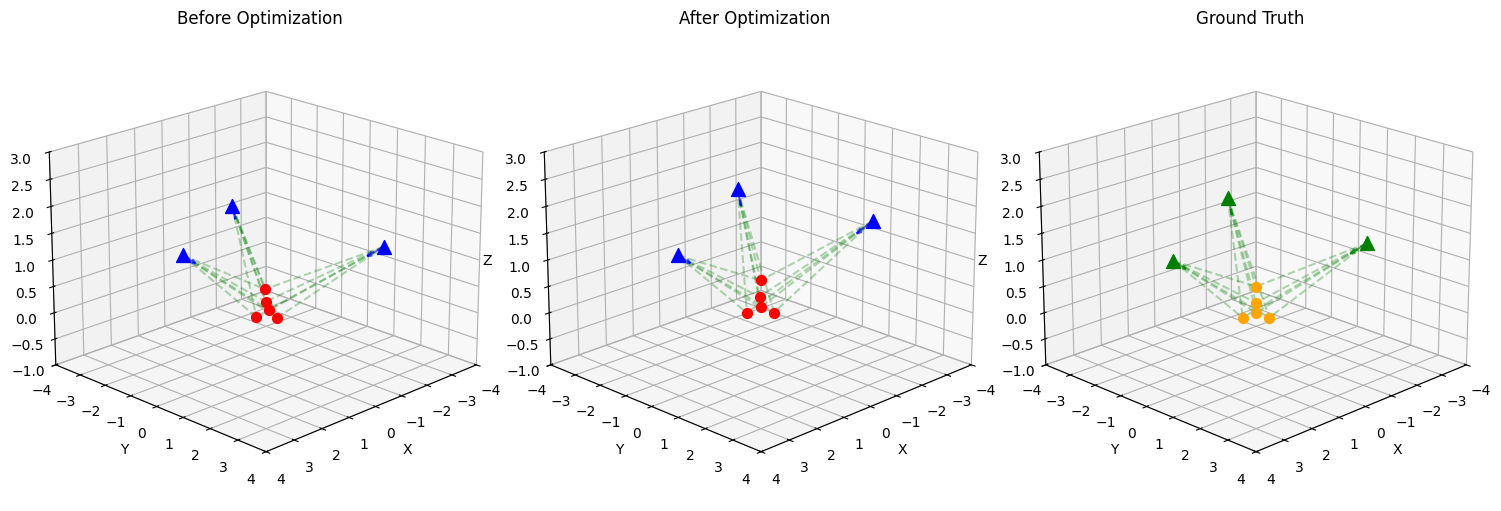


📊 최적화 정확도:
   카메라 0 위치 오차: 0.0973m
   카메라 1 위치 오차: 0.4104m
   카메라 2 위치 오차: 0.2334m

   평균 카메라 위치 오차: 0.2471m
   평균 랜드마크 위치 오차: 0.1144m


In [79]:
# 3D 시각화
fig = plt.figure(figsize=(15, 5))

# 최적화 전
ax1 = fig.add_subplot(131, projection='3d')
ax1.set_title('Before Optimization')

# 카메라 그리기
for i, pose in enumerate(problem['initial_poses']):
    pos = [float(p) for p in pose.t]
    ax1.scatter(pos[0], pos[1], pos[2], c='blue', s=100, marker='^')
    # 카메라 방향
    z_axis = pose.R.to_rotation_matrix()[:, 2]
    z_axis = [float(z) for z in z_axis]
    ax1.quiver(pos[0], pos[1], pos[2],
               -z_axis[0], -z_axis[1], -z_axis[2],  # 카메라는 -Z 방향을 봄
               length=0.5, color='blue', alpha=0.6)

# 랜드마크 그리기
for landmark in problem['initial_landmarks']:
    lm = [float(l) for l in landmark]
    ax1.scatter(lm[0], lm[1], lm[2], c='red', s=50)

# 관측선 그리기 (있는 경우)
for (cam_idx, lm_idx) in problem['measurements'].keys():
    cam_pos = [float(p) for p in problem['initial_poses'][cam_idx].t]
    lm_pos = [float(l) for l in problem['initial_landmarks'][lm_idx]]
    ax1.plot([cam_pos[0], lm_pos[0]], 
             [cam_pos[1], lm_pos[1]], 
             [cam_pos[2], lm_pos[2]], 'g--', alpha=0.3)

# 최적화 후
ax2 = fig.add_subplot(132, projection='3d')
ax2.set_title('After Optimization')

# 최적화가 수행된 경우에만 최적화된 값 사용
if len(problem['measurements']) > 0 and 'result' in locals():
    # 최적화된 결과 가져오기
    if hasattr(result, 'optimized_values'):
        optimized_values = result.optimized_values
    elif hasattr(result, 'values'):
        optimized_values = result.values
    else:
        optimized_values = values  # 초기값 사용
else:
    optimized_values = values  # 측정값이 없으면 초기값 사용

# 최적화된 카메라
for i in range(len(problem['initial_poses'])):
    if f"T_{i}" in optimized_values:
        pose = optimized_values[f"T_{i}"]
        pos = [float(p) for p in pose.t]
        ax2.scatter(pos[0], pos[1], pos[2], c='blue', s=100, marker='^')
        z_axis = pose.R.to_rotation_matrix()[:, 2]
        z_axis = [float(z) for z in z_axis]
        ax2.quiver(pos[0], pos[1], pos[2],
                   -z_axis[0], -z_axis[1], -z_axis[2],  # 카메라는 -Z 방향을 봄
                   length=0.5, color='blue', alpha=0.6)

# 최적화된 랜드마크
for j in range(len(problem['initial_landmarks'])):
    if f"L_{j}" in optimized_values:
        landmark = optimized_values[f"L_{j}"]
        lm = [float(l) for l in landmark]
        ax2.scatter(lm[0], lm[1], lm[2], c='red', s=50)

# 관측선 그리기
for (cam_idx, lm_idx) in problem['measurements'].keys():
    if f"T_{cam_idx}" in optimized_values and f"L_{lm_idx}" in optimized_values:
        cam_pos = [float(p) for p in optimized_values[f"T_{cam_idx}"].t]
        lm_pos = [float(l) for l in optimized_values[f"L_{lm_idx}"]]
        ax2.plot([cam_pos[0], lm_pos[0]], 
                 [cam_pos[1], lm_pos[1]], 
                 [cam_pos[2], lm_pos[2]], 'g--', alpha=0.3)

# Ground truth
ax3 = fig.add_subplot(133, projection='3d')
ax3.set_title('Ground Truth')

for pose in problem['true_poses']:
    pos = [float(p) for p in pose.t]
    ax3.scatter(pos[0], pos[1], pos[2], c='green', s=100, marker='^')
    z_axis = pose.R.to_rotation_matrix()[:, 2]
    z_axis = [float(z) for z in z_axis]
    ax3.quiver(pos[0], pos[1], pos[2],
               -z_axis[0], -z_axis[1], -z_axis[2],  # 카메라는 -Z 방향을 봄
               length=0.5, color='green', alpha=0.6)

for landmark in problem['true_landmarks']:
    lm = [float(l) for l in landmark]
    ax3.scatter(lm[0], lm[1], lm[2], c='orange', s=50)

# 관측선 그리기
for (cam_idx, lm_idx) in problem['measurements'].keys():
    cam_pos = [float(p) for p in problem['true_poses'][cam_idx].t]
    lm_pos = [float(l) for l in problem['true_landmarks'][lm_idx]]
    ax3.plot([cam_pos[0], lm_pos[0]], 
             [cam_pos[1], lm_pos[1]], 
             [cam_pos[2], lm_pos[2]], 'g--', alpha=0.3)

# 축 설정
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])
    ax.set_zlim([-1, 3])
    ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

# 에러 분석
print("\n📊 최적화 정확도:")

# 측정값이 있는 경우에만 에러 계산
if len(problem['measurements']) > 0 and 'result' in locals():
    pose_errors = []
    for i in range(len(problem['true_poses'])):
        true_pose = problem['true_poses'][i]
        if f"T_{i}" in optimized_values:
            opt_pose = optimized_values[f"T_{i}"]
            
            # Convert to numpy arrays for error calculation
            true_pos = np.array([float(p) for p in true_pose.t])
            opt_pos = np.array([float(p) for p in opt_pose.t])
            
            pos_error = np.linalg.norm(true_pos - opt_pos)
            pose_errors.append(pos_error)
            print(f"   카메라 {i} 위치 오차: {pos_error:.4f}m")

    landmark_errors = []
    for j in range(len(problem['true_landmarks'])):
        true_lm = problem['true_landmarks'][j]
        if f"L_{j}" in optimized_values:
            opt_lm = optimized_values[f"L_{j}"]
            
            # Convert to numpy arrays
            true_lm_np = np.array([float(l) for l in true_lm])
            opt_lm_np = np.array([float(l) for l in opt_lm])
            
            lm_error = np.linalg.norm(true_lm_np - opt_lm_np)
            landmark_errors.append(lm_error)

    if pose_errors:
        print(f"\n   평균 카메라 위치 오차: {np.mean(pose_errors):.4f}m")
    if landmark_errors:
        print(f"   평균 랜드마크 위치 오차: {np.mean(landmark_errors):.4f}m")
else:
    print("   측정값이 없어 최적화가 수행되지 않았습니다.")
    print("   카메라가 랜드마크를 제대로 관측하도록 배치를 조정하세요.")

## 6. ATAN 카메라 모델: 광각 렌즈의 세계 🐟

이론에서 배운 고급 카메라 모델을 실제로 구현해봅시다.

### 핀홀을 넘어서: 왜 ATAN이 필요한가? 🤔

표준 핀홀 모델은 좁은 시야각(~60°)에만 적합합니다. 하지만 현대 응용에서는:

| 응용 분야 | 필요 FOV | 카메라 타입 | ATAN 필요성 |
|----------|---------|-----------|------------|
| 📷 액션캠 (GoPro) | 170° | 초광각 | 필수 |
| 🚗 자율주행 서라운드뷰 | 180°+ | 어안 | 필수 |
| 🤖 실내 로봇 | 120° | 광각 | 권장 |
| 🏠 보안 카메라 | 150° | 광각 | 권장 |
| 🚁 드론 장애물 회피 | 140° | 광각 | 권장 |

### 핀홀 vs ATAN: 핵심 차이점 🔑

**핀홀 모델 (선형 투영)**:
```
실제 각도:  0°   30°   60°   90°
이미지 위치: |    |     |     | → 무한대로 발산!
```

**ATAN 모델 (비선형 압축)**:
```
실제 각도:  0°   30°   60°   90°   120°   180°
이미지 위치: |    |    |   |  |  | → 이미지 안에 모두 포함!
```

### ATAN 모델의 수학적 원리 🧮

**핀홀**: `r = f · tan(θ)`  
**ATAN**: `r = (2f/ω) · atan(ω · tan(θ))`

여기서:
- `θ`: 광축으로부터의 각도
- `ω`: 왜곡 파라미터 (0.5~2.0)
- `f`: 초점 거리

**ω의 영향**:
- ω < 1: 약한 어안 효과
- ω = 1: 중간 어안
- ω > 1: 강한 어안 효과

### 실무에서의 ATAN 활용 사례 🌍

1. **테슬라 오토파일럿** 🚗
   - 8개 어안 카메라로 360° 커버
   - ATAN 모델로 정확한 3D 재구성
   - 사각지대 없는 완벽한 인지

2. **DJI 드론** 🚁
   - 전방 어안 카메라로 장애물 감지
   - 넓은 FOV로 안전한 자율비행
   - 실시간 3D 매핑

3. **구글 스트리트뷰** 🗺️
   - 360° 파노라마 캡처
   - ATAN 모델로 정확한 스티칭
   - 왜곡 없는 거리 뷰

### 어안 SLAM의 도전과제와 해결책 🎯

| 도전과제 | 문제점 | 해결책 |
|---------|--------|--------|
| **특징 검출** | 가장자리 왜곡 심함 | 중앙 가중치 적용 |
| **특징 매칭** | 스케일 변화 큼 | 다중 스케일 매칭 |
| **캘리브레이션** | 복잡한 왜곡 모델 | 더 많은 캘리브레이션 이미지 |
| **계산 비용** | 비선형 투영 느림 | 룩업 테이블 사용 |

### 🔧 어안 카메라 실전 팁:
```python
def fisheye_feature_weighting(features, image_center):
    """어안 이미지의 특징점 가중치 계산"""
    
    weights = []
    max_radius = np.linalg.norm(image_center)
    
    for feature in features:
        # 중심에서의 거리
        dist = np.linalg.norm(feature.pt - image_center)
        
        # 가장자리로 갈수록 신뢰도 감소
        weight = 1.0 - 0.5 * (dist / max_radius)**2
        
        # 극단적인 가장자리는 제외
        if dist / max_radius > 0.9:
            weight = 0
            
        weights.append(weight)
    
    return weights
```

### 어안 vs 핀홀 선택 가이드 📋

```python
def choose_camera_model(application):
    """응용에 따른 카메라 모델 선택"""
    
    if application.fov_required > 120:
        return "ATAN/Fisheye 필수"
    elif application.fov_required > 90:
        return "ATAN 권장, 핀홀도 가능"
    elif application.accuracy_critical:
        return "핀홀 권장 (더 정확)"
    else:
        return "핀홀로 충분"
```

> 💡 **실무 경험**: 어안 렌즈는 넓은 시야를 제공하지만, 
> 정확한 3D 재구성을 위해서는 세심한 캘리브레이션과 특별한 처리가 필요합니다!

🐟 ATAN (Fisheye) 카메라 모델:
   왜곡 파라미터 ω: 0.5


/home/user1/ROS2_Workspace/Symforce_ws/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user1/ROS2_Workspace/Symforce_ws/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user1/ROS2_Workspace/Symforce_ws/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user1/ROS2_Workspace/Symforce_ws/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user1/ROS2_Workspace/Symforce_ws/.venv/lib/python3.10/site-packages/

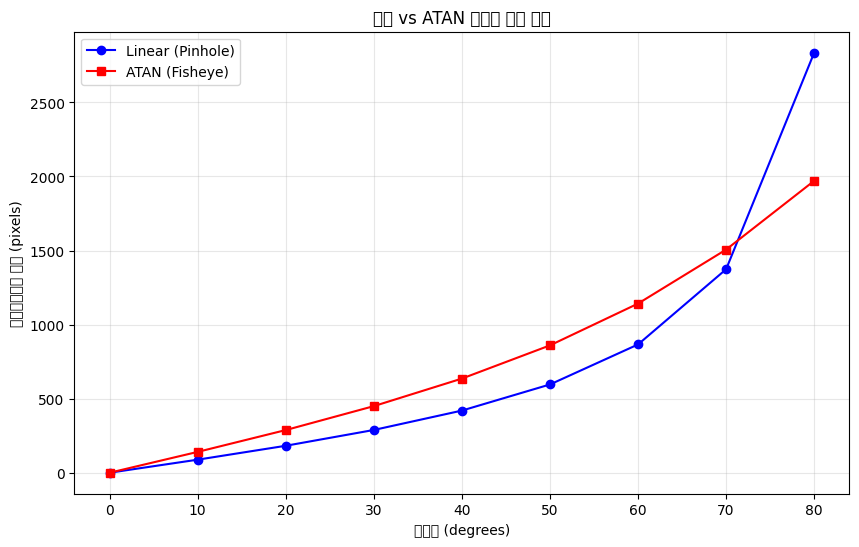


💡 ATAN 모델의 특징:
   - 광각에서도 안정적인 투영
   - 이미지 가장자리에서 압축 효과
   - 180도 이상의 FOV 지원 가능

🎯 85도에서의 투영 비교:
   선형 모델: 중심에서 5715.0 픽셀 (이미지 밖!)
   ATAN 모델: 중심에서 2236.1 픽셀 (이미지 안에 포함)


In [80]:
# ATAN 카메라 모델 (fisheye 렌즈)
atan_cal = sf.ATANCameraCal(
    focal_length=[400.0, 400.0],
    principal_point=[320.0, 240.0],
    omega=0.5  # 왜곡 파라미터
)

print("🐟 ATAN (Fisheye) 카메라 모델:")
print(f"   왜곡 파라미터 ω: {float(atan_cal.omega)}")

# 선형 vs ATAN 비교
test_angles = np.linspace(0, 80, 9)  # 0도에서 80도까지

linear_pixels = []
atan_pixels = []

for angle_deg in test_angles:
    angle_rad = np.deg2rad(angle_deg)
    
    # 카메라 중심에서 angle만큼 벗어난 점
    # 숫자 값으로 직접 생성
    x = float(np.sin(angle_rad))
    y = 0.0
    z = float(np.cos(angle_rad))
    
    # 선형 투영 - PosedCamera 대신 직접 계산
    if z > 0:
        u_linear = 500.0 * x / z + 320.0
        linear_pixels.append(u_linear - 320.0)  # 중심에서의 거리
    else:
        linear_pixels.append(np.nan)
    
    # ATAN 투영 - 직접 계산
    # ATAN 모델: r = (2f/ω) * atan(ω * r_cam / z)
    # where r_cam = sqrt(x^2 + y^2)
    if z > 0:
        r_cam = np.sqrt(x**2 + y**2)
        theta = np.arctan2(r_cam, z)
        omega_val = 0.5
        r_atan = (2 * 400.0 / omega_val) * np.arctan(omega_val * np.tan(theta))
        
        # 픽셀 좌표로 변환 (x 방향만 고려)
        if r_cam > 0:
            u_atan = 320.0 + r_atan * (x / r_cam)
        else:
            u_atan = 320.0
        atan_pixels.append(u_atan - 320.0)
    else:
        atan_pixels.append(np.nan)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(test_angles, linear_pixels, 'b-o', label='Linear (Pinhole)')
plt.plot(test_angles, atan_pixels, 'r-s', label='ATAN (Fisheye)')
plt.xlabel('입사각 (degrees)')
plt.ylabel('이미지에서의 거리 (pixels)')
plt.title('선형 vs ATAN 카메라 모델 비교')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n💡 ATAN 모델의 특징:")
print("   - 광각에서도 안정적인 투영")
print("   - 이미지 가장자리에서 압축 효과")
print("   - 180도 이상의 FOV 지원 가능")

# 실제 예제: 극단적인 각도에서의 차이
extreme_angle = 85  # 거의 90도
angle_rad = np.deg2rad(extreme_angle)
x = float(np.sin(angle_rad))
z = float(np.cos(angle_rad))

if z > 0:
    # 선형 모델
    u_linear = 500.0 * x / z + 320.0
    dist_linear = u_linear - 320.0
    
    # ATAN 모델
    r_cam = x  # y=0이므로
    theta = np.arctan2(r_cam, z)
    omega_val = 0.5
    r_atan = (2 * 400.0 / omega_val) * np.arctan(omega_val * np.tan(theta))
    u_atan = 320.0 + r_atan
    dist_atan = u_atan - 320.0
    
    print(f"\n🎯 {extreme_angle}도에서의 투영 비교:")
    print(f"   선형 모델: 중심에서 {dist_linear:.1f} 픽셀 (이미지 밖!)")
    print(f"   ATAN 모델: 중심에서 {dist_atan:.1f} 픽셀 (이미지 안에 포함)")

## 7. 요약: Visual SLAM 마스터가 되는 여정 🎊

축하합니다! 이론과 실습을 통해 Visual SLAM의 핵심을 마스터했습니다.

### 🎓 여러분이 습득한 핵심 역량

1. **카메라 모델 마스터리** 📷
   - 핀홀 모델의 수학적 원리와 구현
   - ATAN/어안 모델로 광각 처리
   - 실무에 맞는 모델 선택 능력

2. **수치적 안정성 보장** 🛡️
   - epsilon으로 특이점 처리
   - 카메라 뒤의 점 안전하게 처리
   - 프로덕션 수준의 강건한 코드

3. **좌표 변환 전문가** 🌐
   - 월드 ↔ 카메라 ↔ 이미지 자유자재 변환
   - PosedCamera로 깔끔한 추상화
   - 좌표계 오류 디버깅 능력

4. **Bundle Adjustment 실전 구현** 🎯
   - 재투영 오차 함수 설계
   - 대규모 최적화 문제 해결
   - 수렴 분석과 성능 최적화

### 💡 기억해야 할 핵심 통찰

1. **"측정할 수 없으면 개선할 수 없다"**
   - 항상 재투영 오차를 측정하고 시각화하라

2. **"좋은 초기값이 반이다"**
   - Bundle Adjustment도 좋은 시작점이 필요

3. **"시각화는 디버깅의 왕도"**
   - 숫자보다 그림이 문제를 빨리 보여준다

4. **"epsilon은 작지만 위대하다"**
   - 수치적 안정성이 시스템의 신뢰성을 결정

5. **"실무는 이론과 다르다"**
   - 노이즈, 이상치, 캘리브레이션 오류를 항상 고려

### 🚀 다음 단계: 실전 프로젝트

**입문 프로젝트 (1-2주)**:
```python
# 1. 웹캠으로 간단한 AR 앱
- 체커보드 추적
- 가상 객체 오버레이
- 실시간 포즈 추정

# 2. 스마트폰 3D 스캐너
- 연속 사진에서 3D 재구성
- Bundle Adjustment 적용
- 메시 생성 및 텍스처링
```

**중급 프로젝트 (1개월)**:
```python
# 1. 실내 로봇 Visual SLAM
- 실시간 특징 추적
- 키프레임 기반 매핑
- 루프 클로저 구현

# 2. 드론 자율 비행
- Visual Odometry
- 장애물 회피
- 경로 계획 통합
```

**고급 프로젝트 (3개월+)**:
```python
# 1. 다중 카메라 SLAM
- 스테레오/멀티뷰 시스템
- IMU/GPS 센서 융합
- 대규모 최적화

# 2. 의미론적 SLAM
- 딥러닝 객체 인식
- 의미 정보 포함 지도
- 동적 객체 처리
```

### 📚 더 깊이 학습하기 위한 리소스

**필독 논문**:
- "Bundle Adjustment - A Modern Synthesis" (Triggs et al., 2000)
- "ORB-SLAM3: An Accurate Open-Source Library" (Campos et al., 2021)
- "Visual-Inertial Monocular SLAM" (Mur-Artal & Tardós, 2017)

**추천 도서**:
- 📘 "Multiple View Geometry in Computer Vision" - 바이블
- 📗 "Computer Vision: Algorithms and Applications" - 실용적
- 📙 "State Estimation for Robotics" - 이론적 기초

**온라인 강좌**:
- 🎓 TUM의 "Visual Navigation for Flying Robots"
- 🎓 Cyrill Stachniss의 "SLAM Course"
- 🎓 Georgia Tech의 "Computer Vision"

### 🏆 여러분의 Visual SLAM 여정

```python
def your_visual_slam_journey():
    # Chapter 1-9: 기초 다지기
    master_rotations()
    understand_pose_graphs()
    implement_optimization()
    
    # Chapter 10: Visual SLAM 정복
    implement_camera_models()
    master_bundle_adjustment()
    handle_numerical_edge_cases()
    
    # 다음 단계: 실전 응용
    while True:
        build_amazing_projects()
        contribute_to_community()
        push_boundaries()
        
    return "Visual SLAM Expert 🎓"
```

### 🙏 마지막 메시지

여러분은 이제 Visual SLAM의 핵심을 이해하고 구현할 수 있는 능력을 갖추었습니다. 
이것은 끝이 아니라 새로운 시작입니다!

**기억하세요**:
- 모든 전문가도 처음엔 초보자였습니다
- 실패는 성공으로 가는 디딤돌입니다
- 꾸준한 연습이 완벽을 만듭니다

**여러분의 도전을 응원합니다!** 🚀

이제 나가서 세상을 3D로 재구성하세요!
여러분이 만들 놀라운 Visual SLAM 프로젝트를 기대합니다.

---

*"비전은 보는 것이 아니라 이해하는 것이다."*  
*- 컴퓨터 비전의 선구자들*

### 🔧 최종 조언:
```python
# Visual SLAM 성공의 비결
def recipe_for_success():
    ingredients = {
        '이론_이해': '수학적 기초를 탄탄히',
        '실습_경험': '손으로 직접 구현하며 배우기',
        '디버깅_인내': '문제를 즐기는 마음가짐',
        '커뮤니티_참여': '질문하고 공유하기',
        '지속적_학습': '새로운 기술 따라잡기'
    }
    
    return mix(ingredients, passion=float('inf'))

# 여러분의 성공을 확신합니다!
success = recipe_for_success()
print(f"🎉 축하합니다! 이제 여러분은 {success}를 갖추었습니다!")
```

**행운을 빕니다! 화이팅! 💪✨**

## 🏋️ Practice Exercises: Build Your Skills!

### Exercise 1: Stereo Vision - Depth from Two Views 👀

Implement stereo triangulation to recover 3D points from two cameras:

```python
def triangulate_stereo_point(
    left_pixel: sf.V2,
    right_pixel: sf.V2,
    left_camera: sf.PosedCamera,
    right_camera: sf.PosedCamera,
    epsilon: sf.Scalar
) -> sf.V3:
    """
    Triangulate a 3D point from stereo observations
    
    Hints:
    1. Back-project pixels to rays
    2. Find closest point between two rays
    3. Handle parallel rays with epsilon
    """
    pass
```

**Challenge**: What happens when cameras are too close? Too far?

### Exercise 2: Rolling Shutter Compensation 📸

Modern cameras don't capture all pixels simultaneously. Model and correct this:

```python
def rolling_shutter_correction(
    pixel: sf.V2,
    camera_velocity: sf.V6,  # Linear and angular velocity
    row_readout_time: float,
    image_height: int
) -> sf.V2:
    """
    Correct pixel position for rolling shutter effect
    
    Key insight: Top rows captured before bottom rows
    """
    pass
```

**Real-world impact**: Drone racing, fast robot motion

### Exercise 3: Multi-Camera Rig Calibration 🎥

Design a 360° camera system with 4 cameras:

```python
def design_quad_camera_rig() -> List[sf.Pose3]:
    """
    Return optimal poses for 4 cameras to maximize coverage
    
    Consider:
    - Field of view overlap for feature matching
    - Minimize blind spots
    - Structural constraints (camera size)
    """
    pass
```

**Application**: Autonomous vehicle surround view

### Exercise 4: Robust Bundle Adjustment 💪

Enhance the basic Bundle Adjustment with outlier rejection:

```python
def huber_loss(error: float, delta: float = 1.0) -> float:
    """
    Implement Huber robust loss function
    
    Linear for small errors, square root for large errors
    """
    pass

def robust_bundle_adjustment(
    # ... standard parameters ...
    loss_function = huber_loss
):
    """
    Bundle adjustment resistant to outliers
    """
    pass
```

**Why it matters**: Real data always has outliers!

### Exercise 5: Visual-Inertial Fusion 🔄

Combine camera measurements with IMU data:

```python
def visual_inertial_residual(
    camera_pose_t0: sf.Pose3,
    camera_pose_t1: sf.Pose3,
    imu_measurements: List[sf.V6],  # Accelerometer + gyroscope
    dt: float
) -> sf.V6:
    """
    Fuse visual and inertial measurements
    
    IMU provides high-rate relative motion
    Vision provides drift-free corrections
    """
    pass
```

**Challenge**: Handle different sensor rates (Camera: 30Hz, IMU: 200Hz)

### Mini-Project Ideas 💡

**1. Phone-based 3D Scanner** 📱
- Use your phone camera
- Detect features (ARCore/ARKit help)
- Run Bundle Adjustment
- Export 3D model

**2. Visual Odometry for RC Car** 🏎️
- Mount camera on toy car
- Track motion without GPS
- Compare with wheel odometry
- Build 2D map of your room

**3. Fisheye SLAM for Drone** 🚁
- Simulate fisheye camera
- Generate synthetic data
- Test ATAN vs pinhole model
- Measure accuracy difference

**4. Time-lapse 3D Reconstruction** ⏰
- Take photos of object on turntable
- Detect and match features
- Run Bundle Adjustment
- Create 3D model

### Solution Hints 🗝️

**Exercise 1**: Use SVD to find closest point between skew lines

**Exercise 2**: Each row has different timestamp, adjust pose accordingly

**Exercise 3**: 90° apart horizontally, slight downward tilt

**Exercise 4**: Switch between L2 and L1 norm based on error magnitude

**Exercise 5**: Integrate IMU between camera frames, use as prediction

### Debugging Tips 🐛

1. **Always visualize first** - Plot before optimizing
2. **Check coordinate systems** - #1 source of bugs
3. **Verify with synthetic data** - Know ground truth
4. **Start with 2 cameras** - Then scale up
5. **Print matrix shapes** - Catch dimension errors

### Share Your Solutions! 🌟

Built something cool? Share it:
- GitHub: Tag with #SymForce #VisualSLAM
- Twitter: Show your 3D reconstructions
- Blog: Write about your learning journey

Remember: The best way to learn is by building! 🚀

In [81]:
# 연습 문제를 위한 시작 코드

# 문제 1: 스테레오 삼각측량
def triangulate_stereo_point(
    left_pixel: sf.V2,
    right_pixel: sf.V2,
    left_camera: sf.PosedCamera,
    right_camera: sf.PosedCamera,
    epsilon: sf.Scalar
) -> sf.V3:
    """두 카메라 관측으로부터 3D 점 복원"""
    # 여기에 구현
    pass

In [82]:
# Let's test the fixed create_bundle_adjustment_problem function
import numpy as np

# Test camera orientation calculation
for i in range(3):
    angle = 2 * np.pi * i / 3
    x = 3 * np.cos(angle)
    y = 3 * np.sin(angle)
    z = 1.5
    
    cam_pos = np.array([x, y, z])
    target = np.array([0, 0, 0])
    
    # Z axis should point from target to camera (camera looks in -Z direction)
    z_axis = cam_pos - target
    z_axis = z_axis / np.linalg.norm(z_axis)
    
    # The camera forward direction (-Z) should point toward origin
    cam_forward = -z_axis
    
    print(f"Camera {i}:")
    print(f"  Position: {cam_pos}")
    print(f"  Z-axis: {z_axis}")
    print(f"  Forward (-Z): {cam_forward}")
    print(f"  Should point to origin: {target - cam_pos} (normalized: {(target - cam_pos) / np.linalg.norm(target - cam_pos)})")
    print()

Camera 0:
  Position: [3.  0.  1.5]
  Z-axis: [0.89442719 0.         0.4472136 ]
  Forward (-Z): [-0.89442719 -0.         -0.4472136 ]
  Should point to origin: [-3.   0.  -1.5] (normalized: [-0.89442719  0.         -0.4472136 ])

Camera 1:
  Position: [-1.5         2.59807621  1.5       ]
  Z-axis: [-0.4472136   0.77459667  0.4472136 ]
  Forward (-Z): [ 0.4472136  -0.77459667 -0.4472136 ]
  Should point to origin: [ 1.5        -2.59807621 -1.5       ] (normalized: [ 0.4472136  -0.77459667 -0.4472136 ])

Camera 2:
  Position: [-1.5        -2.59807621  1.5       ]
  Z-axis: [-0.4472136  -0.77459667  0.4472136 ]
  Forward (-Z): [ 0.4472136   0.77459667 -0.4472136 ]
  Should point to origin: [ 1.5         2.59807621 -1.5       ] (normalized: [ 0.4472136   0.77459667 -0.4472136 ])



In [83]:
# Test the camera coordinate transformation
print("🧪 Testing camera coordinate transformation...")

# Create a simple test
test_calibration = sf.LinearCameraCal(
    focal_length=[500.0, 500.0],
    principal_point=[320.0, 240.0]
)

# Camera at (3, 0, 1.5) looking at origin
cam_pos = np.array([3.0, 0.0, 1.5])
target = np.array([0.0, 0.0, 0.0])

# Create a simple pose where camera looks along -X axis (toward origin)
# In camera frame: Z points away from target (positive X world), X points down, Y points left
R_matrix = np.array([
    [0, 0, 1],    # Camera X = World Z
    [0, 1, 0],    # Camera Y = World Y  
    [-1, 0, 0]    # Camera Z = -World X (camera looks in -Z direction)
])

# Create pose - camera at (3, 0, 1.5) looking toward origin
test_pose = sf.Pose3(
    R=sf.Rot3.from_rotation_matrix(R_matrix),
    t=sf.V3(3.0, 0.0, 1.5)
)

# Test landmark at origin
test_landmark = sf.V3(0.0, 0.0, 0.0)

# Transform to camera coordinates using inverse
landmark_cam = test_pose.inverse() * test_landmark

print(f"Camera position: {[float(p) for p in test_pose.t]}")
print(f"Target position: {[float(p) for p in test_landmark]}")
print(f"Camera coordinate of origin: {[float(c) for c in landmark_cam]}")
print(f"Z coordinate: {float(landmark_cam[2]):.3f}")

# Expected: Since camera is at (3, 0, 1.5) and looks toward origin,
# the origin should be at approximately (0, 0, 3.35) in camera coordinates
# (distance from camera to origin)

# Let's also test with PosedCamera to verify
posed_camera = sf.PosedCamera(
    pose=test_pose,
    calibration=test_calibration,
    image_size=(640, 480)
)

pixel, is_valid = posed_camera.pixel_from_global_point(test_landmark)
print(f"\nUsing PosedCamera:")
print(f"Pixel: {[float(p) for p in pixel]}")
print(f"Valid: {is_valid}")
print(f"Expected: near center [320, 240] if transformation is correct")

🧪 Testing camera coordinate transformation...
Camera position: [3.0, 0.0, 1.5]
Target position: [0.0, 0.0, 0.0]
Camera coordinate of origin: [1.5, 0.0, -3.0]
Z coordinate: -3.000

Using PosedCamera:
Pixel: [70.0, 240.0]
Valid: 0
Expected: near center [320, 240] if transformation is correct
